<h1 align="center">Predicting Employee Turnover</h1>
<h4 align='center'>Employee Prediction Analysis with Scikit-learn.</h4>

<h4>The Objective</h4>
Being able to rely on your team members is critical to success in any environment and even the most humble role can become the bottleneck that halts production, damaging morale and causing unforseen difficulties. Onboarding new additions and adjusting to new workflows takes time and resources: wouldn't it be great to see these roadblocks coming and be able to plan for them?

In this project I've used Python and scikit-learn to conduct employee turnover analysis to assess the churn within an organization, in an effort to predict and 
reduce future employee turnover. Wages, incentives, workload, satisfaction and absenteeism - by modeling these variable interactions using Decision Trees and Random Forest, we can identify the key variables that play a crucial role in retaining team members. Interactive graphical controls via Jupyter widgets allows the the plots to be modified on the fly as we tune our model, and the results are generated in real time.</p>
<p></p>

<h4>Initial exploration of the data set</h4>
Source: <a href="https://www.kaggle.com/rhuebner/human-resources-data-set" target="_blank">Human Resources Data Set by Dr. Rich Huebner</a>

In this step, I first opened the data set in Excel in order to get a good look at the raw data. After assessing that the data set had enough unique features to be a suitable training set, I duplicated the file and went about cleaning it up. This process was straightforward, although I did end up generating a series of null values, specifically where **Termination Date** and **Reason** are concerned. There were several instances of information being entered incorrectly or not at all; by canvasing through the data set, I was able to ascertain these values. At this point I also anonymized the data by removing any Personally Identifiable Information and removed any columns that I deemed unnecessary to my specific project: things like ethnicity, marital status, and age. We are trying to predict using features that we, as the business, can control. We are not looking to inform discriminatory hiring practices. A specific callout here: while I did remove the **Manager Name** column, I did leave the **Manager ID**. Again, we are trying to identify features that we are able to control: it is important that we are able to identify any patterns involving specific management elements that we discover. I also generated several concatenated columns that I felt might be useful going forward in my analysis. Once I was satified with the way my data was cleaned and formatted, I imported it into the notebook.


In [3]:
from __future__ import print_function
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.legend import Legend
import matplotlib as mpl
import seaborn as sns
import pandas as pd
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [4]:
plt.rcParams['figure.figsize'] = (9,6)

In [5]:

clean_hrdata = pd.read_csv('CLEAN_HRDataset_v14.csv')
clean_hrdata.head()

,EmpStatusID,EmploymentStatus,EmployStatus_Code_Concat,DeptID,Department,Dept_ID_Concat,ManagerID,Manager_Dept,PerfScoreID,Salary,...,DateofTermination,TermReason,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,1,Active,1-Active,5,Production,5-Production,22,22-Production,4,62506,...,NaN,NaN,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,5,VoluntarilyTerminated,5-VoluntarilyTerminated,3,IT/IS,3-IT/IS,4,4-IT/IS,3,104437,...,6/16/2016,careerchange,Indeed,FullyMeets,4.96,3,6,2/24/2016,0,17
2,5,VoluntarilyTerminated,5-VoluntarilyTerminated,5,Production,5-Production,20,20-Production,3,64955,...,9/24/2012,hours,LinkedIn,FullyMeets,3.02,3,0,5/15/2012,0,3
3,1,Active,1-Active,5,Production,5-Production,16,16-Production,3,64991,...,NaN,NaN,Indeed,FullyMeets,4.84,5,0,1/3/2019,0,15
4,5,VoluntarilyTerminated,5-VoluntarilyTerminated,5,Production,5-Production,39,39-Production,3,50825,...,9/6/2016,returntoschool,GoogleSearch,FullyMeets,5.00,4,0,2/1/2016,0,2


Once I had my data clean and imported, I started to investigate any connections I thought might be likely. By using the Pandas crosstab method, I was quickly able to build cross tabulation tables to determine the frequency at which certain data features appear together.

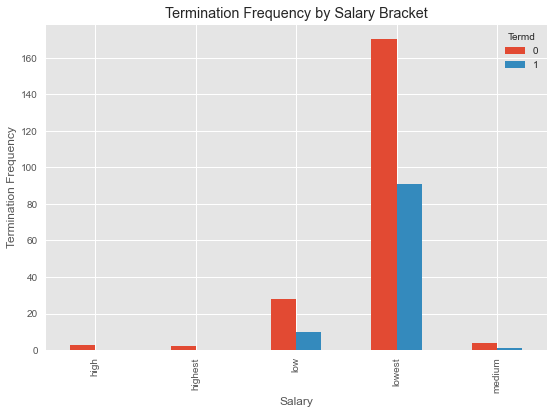

In [6]:
pd.crosstab(clean_hrdata.Salary_Rangeband, clean_hrdata.Termd).plot(kind='bar')
plt.title('Termination Frequency by Salary Bracket')
plt.xlabel('Salary')
plt.ylabel('Termination Frequency')
plt.show()

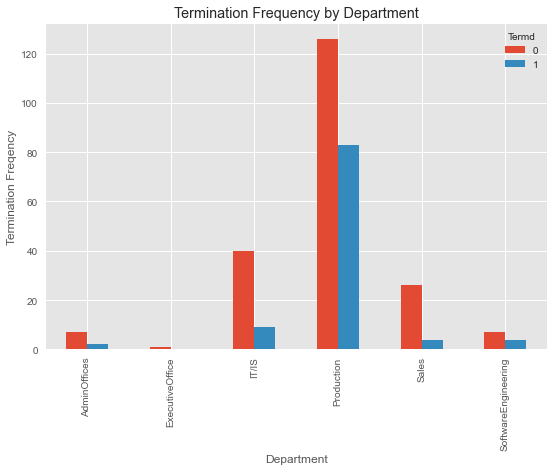

In [7]:
pd.crosstab(clean_hrdata.Department, clean_hrdata.Termd).plot(kind='bar')
plt.title('Termination Frequency by Department')
plt.xlabel('Department')
plt.ylabel('Termination Freqency')
plt.show()

At this point we've already identified two areas where employee churn seems to be at its' highest: **Salary** and **Department**. I was curious to see the overlap between the two features and get a sense of if they were contributing independantly to employee churn, or if there was some correlation involved.

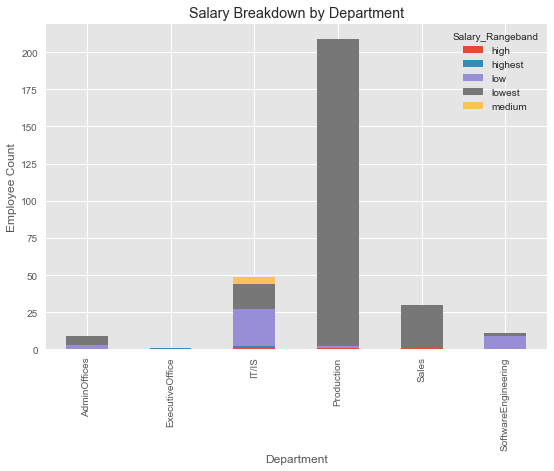

In [8]:
pd.crosstab(clean_hrdata.Department, clean_hrdata.Salary_Rangeband).plot.bar(stacked=True)
plt.title('Salary Breakdown by Department')
plt.xlabel('Department')
plt.ylabel('Employee Count')
plt.show()

The crossover between working in the production department and being in the lowest wage band is very clear here, and suggests a strong connection between these two features. Moving forward, when we consult our feature importnce data we will know to take into consideration the relationship between these two features - the importance of one in determining employee retention may as a side effect pull the importance of the other up as well.

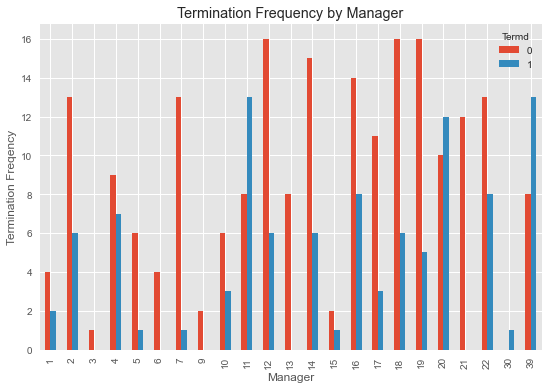

In [9]:
pd.crosstab(clean_hrdata.ManagerID, clean_hrdata.Termd).plot(kind='bar')
plt.title('Termination Frequency by Manager')
plt.xlabel('Manager')
plt.ylabel('Termination Freqency')
plt.show()

I also was curious about the impact individual managers were having on termination rates. My initial look into the rate at which various managers were terminating staff offered less clarity, so I decided to investgate how those numbers looked when broken down by department.

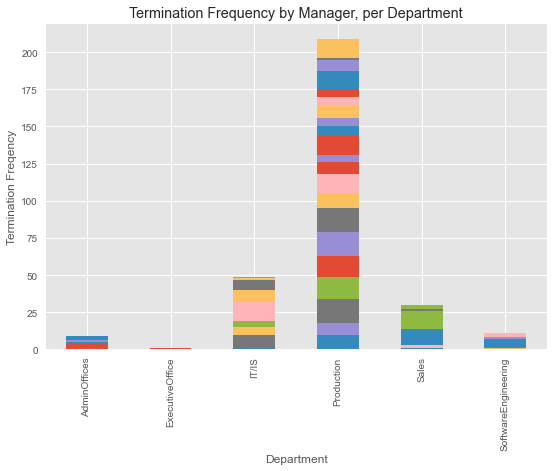

In [10]:
pd.crosstab(clean_hrdata.Department,[clean_hrdata.Termd,clean_hrdata.ManagerID]).plot.bar(stacked=True, legend=False)
plt.title('Termination Frequency by Manager, per Department')
plt.xlabel('Department')
plt.ylabel('Termination Freqency')
plt.show()

Much better! I've removed the legend here for simplicity's sake: all I'm really looking at here is the relative frequency within each column. Outliers in the frequency of termination could indicate that a manager's interaction with their team may be playing a significant role in the numbers. More staff, needing more management, in a larger department leading to in increased representation in the termination numbers - this all makes intuitive sense, and without additional data pertaining to specific aspects of each manager we'll have to be satisfied in saying that the individual managers represented in our data set do not appear to play a statistically significant role in employee churn.

Now that we have a better understanding of our data set as a whole, we can begin prepping our data for use in our Decision Tree and that starts with good feature selection. Even after our initial cleaning, our data set still offers us a lot of information that is repetitive, redundant, or otherwise potentially misleading to the model. Let's start by selecting the columns that we do intend to investigate, and throw those into a new DataFrame.

In [11]:
tree_hrdata = clean_hrdata[['EmploymentStatus','Department','ManagerID','Salary_Rangeband','Termd','Position',
'RecruitmentSource','PerformanceScore','EngagementSurvey','EmpSatisfaction','EmpSatisfaction','DaysLateLast30',
'Absences']].copy()

tree_hrdata.head()

,EmploymentStatus,Department,ManagerID,Salary_Rangeband,Termd,Position,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,EmpSatisfaction,DaysLateLast30,Absences
0,Active,Production,22,lowest,0,ProductionTechnicianI,LinkedIn,Exceeds,4.60,5,5,0,1
1,VoluntarilyTerminated,IT/IS,4,low,1,Sr.DBA,Indeed,FullyMeets,4.96,3,3,0,17
2,VoluntarilyTerminated,Production,20,lowest,1,ProductionTechnicianII,LinkedIn,FullyMeets,3.02,3,3,0,3
3,Active,Production,16,lowest,0,ProductionTechnicianI,Indeed,FullyMeets,4.84,5,5,0,15
4,VoluntarilyTerminated,Production,39,lowest,1,ProductionTechnicianI,GoogleSearch,FullyMeets,5.00,4,4,0,2


<h4>One Hot Encoding Categorical Features</h4>

 We have a lot of strings for our variables, and our algorithm isn't going to know what to do with those. We'll either need to convert them into numerical equivalents, or find a way to simulate those values being entered into our data. We're going to use a method called One Hot or "dummy" encoding. I've used this procedure to simulate boolean values when working with SQL as well, and it's very straight forward. For each unique value in a column we generate a seperate column and assign a value of either 0 or 1, depending on whether that column's value is "true" or "false". 

In [12]:

dum_var = ['Department','Salary_Rangeband','PerformanceScore']

for var in dum_var :
        dum_var = pd.get_dummies(tree_hrdata[var], prefix=var)
        tree_hrdata = tree_hrdata.join(dum_var)

I'm being careful here to append a label for each new column that I'll be generating - after all, this step doesn't do us any good if we can't decypher the inputs on the other end.  
 We'll also confirm that we've made the correct additions with appended labels, by taking quick peek.

In [13]:
tree_hrdata.head()

,EmploymentStatus,Department,ManagerID,Salary_Rangeband,Termd,Position,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,...,Department_SoftwareEngineering,Salary_Rangeband_high,Salary_Rangeband_highest,Salary_Rangeband_low,Salary_Rangeband_lowest,Salary_Rangeband_medium,PerformanceScore_Exceeds,PerformanceScore_FullyMeets,PerformanceScore_NeedsImprovement,PerformanceScore_PIP
0,Active,Production,22,lowest,0,ProductionTechnicianI,LinkedIn,Exceeds,4.60,5,...,0,0,0,0,1,0,1,0,0,0
1,VoluntarilyTerminated,IT/IS,4,low,1,Sr.DBA,Indeed,FullyMeets,4.96,3,...,0,0,0,1,0,0,0,1,0,0
2,VoluntarilyTerminated,Production,20,lowest,1,ProductionTechnicianII,LinkedIn,FullyMeets,3.02,3,...,0,0,0,0,1,0,0,1,0,0
3,Active,Production,16,lowest,0,ProductionTechnicianI,Indeed,FullyMeets,4.84,5,...,0,0,0,0,1,0,0,1,0,0
4,VoluntarilyTerminated,Production,39,lowest,1,ProductionTechnicianI,GoogleSearch,FullyMeets,5.00,4,...,0,0,0,0,1,0,0,1,0,0


Now that we've generated our "dummy" variables, we can remove the redundant columns.  
This is also a great opportunity to remove any NaN values, which our model won't be able to interpret successfully and may inpact our overall accuracy.

In [14]:
tree_hrdata.drop(columns=['EmploymentStatus','Department','Position','Salary_Rangeband','RecruitmentSource','PerformanceScore','ManagerID'], axis = 1, inplace=True)

In [15]:
tree_hrdata.head()

,Termd,EngagementSurvey,EmpSatisfaction,EmpSatisfaction,DaysLateLast30,Absences,Department_AdminOffices,Department_ExecutiveOffice,Department_IT/IS,Department_Production,...,Department_SoftwareEngineering,Salary_Rangeband_high,Salary_Rangeband_highest,Salary_Rangeband_low,Salary_Rangeband_lowest,Salary_Rangeband_medium,PerformanceScore_Exceeds,PerformanceScore_FullyMeets,PerformanceScore_NeedsImprovement,PerformanceScore_PIP
0,0,4.60,5,5,0,1,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
1,1,4.96,3,3,0,17,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,1,3.02,3,3,0,3,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
3,0,4.84,5,5,0,15,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
4,1,5.00,4,4,0,2,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0


<h4>Visualizing the Class Imbalance</h4>
There are many components to a successful Random Forest: quality training data, selecting the right features, the optimization of hyperparameters. Sometimes, the model still fails. Why?

One consideration is the concept of class imbalance. Our algorithm (and indeed, most machine learning algorithms that I am aware of) assumes that our data will be evenly distributed between our potential outcomes. If this is not the case, and we do not adjust for this, our algorithm can tend to favour the majority. My understanding of this phenomenon is that the algorithm's cost function (or error) is attempting to correct for the uneven distribution; but, because it is still just a computer program it is unable to take into account the fact that the imbalance is inherent to the data set ("It's a feature!"). So it's up to us to account for this up front by stratifying our training and validation sets. Failing to address this issue is a surefire way to generate misleading outcomes that at best wastes everyone's time, and at worst can lead to misinformed decision making.

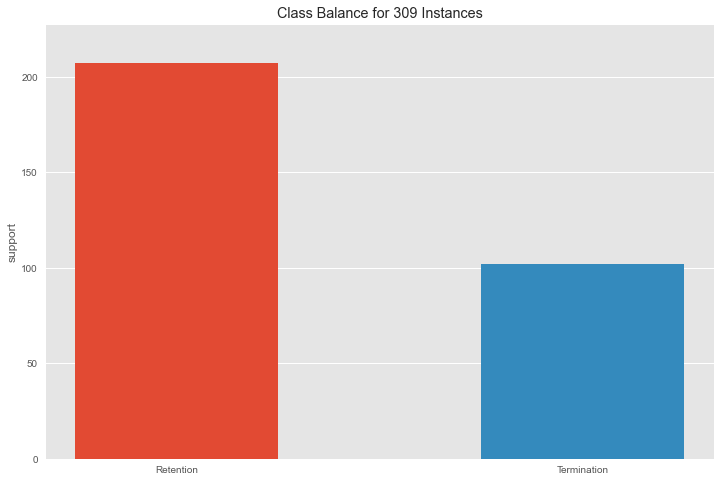

<AxesSubplot:title={'center':'Class Balance for 309 Instances'}, ylabel='support'>

In [16]:
from yellowbrick.target import ClassBalance

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)
visualizer = ClassBalance(labels=['Retention','Termination']).fit(clean_hrdata.Termd)
visualizer.show()

As expected we have an obvious imbalance: more employees stay than quit their jobs!

Going forward we can apply stratified sampling to our training and validation data sets during our modeling process so that the same relative imbalance is carried on throughout our process, and as a result the model doesn't pick up any undesirable habits.

<h4>Create Training and Test Sets</h4>

*Note: Traditionally $X$ is used for the notation, but X and x don't offer enough visual distinction for my liking, so I've gone ahead and very creatively named my variable bigx.*

So now we part out our target vector - whether or not an employment was terminated, and our feature matrix - the variables that we would like to consider in determining the outcome of the target vector.

In [17]:

bigx = tree_hrdata.loc[:, tree_hrdata.columns != 'Termd']
y = tree_hrdata.Termd

Next we'll use the train_test_split function from scikit_learn to generate our training and validation sets from our data, being careful to remeber the importance of statifying our inherently imbalanced distribution.

In [18]:
from sklearn.model_selection import train_test_split
bigx_train, bigx_test, y_train, y_test = train_test_split(bigx,y,random_state=0,test_size=0.2,stratify=y)

In [19]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

<h4>Decision Tree</h4>
Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any prior assumptions being encoded into the data. They can handle numeric and categorical variables (although remember above, we still need to be mindful of the variable's type) with low bias (again, assuming you account for the inherant bias within the data being used). Feature selection makes them robust to noisy or confusing features, making them robust against outliers and edgecases. They're also easily interpretable without any specialized background: you can look at a plot and understand the outcome, even if you might not be able to intuite all of the connections.

The big stumbling point of Decision Tree algorithms are that, generally speaking, they have high variance in their output: as data is fed through the algorithm, repeatable results are not a sure thing. An otherwise very accurate model may work well for a one off exploration; however, it cannot be said to be a good predictor over many iterations.

<blockquote> <b>Quick Reference:</b><br>
 <i>depth</i> is the maximal distance between the root and any leaf node, or the longest path from the root to a leaf.<br>
 <i>min_split</i> is the minimum number of samples required to split a leaf node.<br>
 <i>min_leaf</i> is the minimum number of samples required to be at a leaf node.</blockquote>
 


In [20]:
@interact
def tree_plot(crit=['entropy', 'gini'],
              split=['best','random'],
              depth=IntSlider(min=1,max=30,value=5, continuous_update=False),
              min_split=IntSlider(min=2,max=11,value=4, continuous_update=False),
              min_leaf=IntSlider(min=2,max=11,value=2, continuous_update=False)) :
    tree_plot = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter=split,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf)

    tree_plot.fit(bigx_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, tree_plot.predict(bigx_train))))
    print('Decision Tree Validation Accuracy: {:.3}'.format(accuracy_score(y_test, tree_plot.predict(bigx_test))))

    graph = Source(tree.export_graphviz(tree_plot,out_file=None,
                                        feature_names=bigx_train.columns,
                                        class_names=['Retention','Termination'],
                                        filled=True))

    display(Image(data=graph.pipe(format='png')))
    return tree_plot

interactive(children=(Dropdown(description='crit', options=('entropy', 'gini'), value='entropy'), Dropdown(des…

***(On my initial run of this cell, it returned an accuracy of 100% on stock settings for both training and validation. I immediately knew something was up. I discovered that I had neglected to remove the **EmploymentStatus** feature from our model's calculations. The model in turn made the correct - but misguided - assertion that the leading contribution to someone having their employment terminated was to in fact be employed there in the first place! Not wrong, but also not very helpful!)***

For each note, a series of values are listed. First we have the feature that node is inspecting, alongside the decision boundary value. The entropy is next, and broadly speaking it's a measurement of how messy or disorganized the data being considered is: low entropy values means tidy data, and tidy data is accurate data. If you would prefer, you can opt to display the Gini Index value: a measurement of the probability that the element will be misclassified. Samples refers to, well, the number of samples being considered at this node; value represents the classification split of those samples as per the *class_names* variable (['Retention','Termination'] in our case). The nodes are actually color coded as well, for a quick overview of how radical the split is in a given node. The last entry is simply the Decision Tree's determination of that node.

Now that our model has worked through the data that we've provided, we should examine which features ended up being most influencial in determining a correct outcome.

In [21]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")
from yellowbrick.classifier import ROCAUC

In [22]:
@interact
def tree_feat(crit=['entropy', 'gini']) :
    tree_feat = DecisionTreeClassifier(class_weight=None, criterion=crit, max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, random_state=0,
            splitter='best')

    viz = FeatureImportances(tree_feat)
    viz.fit(bigx_train, y_train)
    viz.show() ;

interactive(children=(Dropdown(description='crit', options=('entropy', 'gini'), value='entropy'), Output()), _…

Let's see what our data is telling us.  

What I found to be of immediate interest is that our model did not find any strong correlation between an employee's wage and the likelihood of their termination, outside of those inside the lowest wage band. Refering back to our initial exploration, we can see that the two departments that are comprised mostly of employees within that bracket are the ones our model correlated to a likelihood of termination. These values feed into eachother, and any increase in "departments with high % of lowest paid employees" will naturally result in the increase of employees in the lowest paid bracket or vice versa. It would seem advisable to treat these as a matched pair of features until we can conduct further analysis.  

Performance scores on both extremes are also represented. While we might expect to see the low end of this spectrum, the fact that our model also cites those "fully meeting expectations" as more likely to be classified as terminations indicates that the company may not be doing enough to retain these valuable team members. These are the staffers who might be excelling in their current roles, but reporting a poor level of engagement with their work. This is a good KPI to keep track of as it allows for intervention before someone starts looking for "greener pastures."

Beyond that, we see that a lack of punctuality, absenteeism and low employee engagement are also significant precursors to termination. These three also feel interconnected, and our numbers demonstrate this. There is a direct relationship between being late and missing work, and a further correlation between these two and overall employee engagement.

In each of these cases, I've gone back and included Excel visualizations to explore these relationships. Even then, we're left with questions. How often will a team member show up late before their attendance starts to suffer, and at what point does that absenteeism become permanent. What is the breakpoint on the engagement survey, anyway?  

Now that we have identified our top contributing features, we could drill down and further explore these questions. By tailoring new training and validation sets from our data, we can determine how specific features impact the overall model. That information can be used to inform policy, coach behavior, and otherwise result in increased staff retention. Ultimately our goal here should be to build out indicators that strong, contributing members of the team may be likely to leave so that we can act in a way to diminish that likelihood.

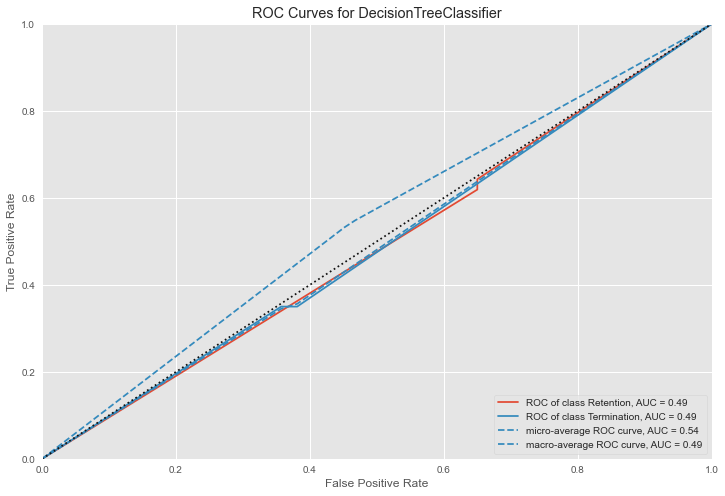

In [27]:
tree_roc = DecisionTreeClassifier(max_depth=None, random_state=0)

visualizer = ROCAUC(tree_roc,classes=['Retention','Termination'])
visualizer.fit(bigx_train, y_train)
visualizer.score(bigx_test, y_test)
visualizer.poof() ;

Lastly, let's explore our model's effectiveness. Measuring our performance is an important bookkeeping step, ensuring that our model is performing as intended and up to the specific tolerances as dictated by its intended use.

The visualization charts our Receiver Operating Characteristics against a breakpoint denoting an equal likelihood of true and false positives or the minimum possible seperability of the characteristics. The slope of the line describes the simultaneous maximal representation of the true positive rate and minimal representation of the false positive rate. It also lets us calculate the area under the curve (AUC), which represents the computational relationship between the two "positive" states. We can use our ROCAUC chart to understand how the interplay between sensitivity and specificity impacts our model as we make parameter adjustments, by logging the ROC/AUC metrics for comparison.

<h4>The Random Forest</h4>
"Low bias, high variance" is the hallmark of a Deicison Tree: an average model might perform well, but unpredictably. How do we deal with this issue of variance? Well, if one tree is highly variable then more trees should drive that variance down.  

Many trees. Like a forest.

In [24]:
@interact
def forest_plot(crit=['entropy','gini'],
                 bootstrap=['True','False'],
                 depth=IntSlider(min=1,max=30,value=5, continuous_update=False),
                 forests=IntSlider(min=1,max=100,value=97,continuous_update=False),
                 min_split=IntSlider(min=2,max=10,value=4, continuous_update=False),
                 min_leaf=IntSlider(min=2,max=10,value=2, continuous_update=False)):
    
    
    forest_plot = RandomForestClassifier(random_state=1,
                                     criterion=crit,
                                     bootstrap=bootstrap,
                                     n_estimators=forests,
                                     max_depth=depth,
                                     min_samples_split=min_split,
                                     min_samples_leaf=min_leaf,
                                     n_jobs=-1,
                                     verbose=False)
    forest_plot.fit(bigx_train, y_train)

    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, forest_plot.predict(bigx_train))))
    print('Random Forest Validation (Test) Accuracy: {:.3}'.format(accuracy_score(y_test, forest_plot.predict(bigx_test))))
   
    num_tree=forest_plot.estimators_[0]
    print('Visualizing Tree #',0)
   
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                        feature_names=bigx_train.columns,
                                        class_names=['Retention','Termination'],
                                        filled=True))
    
    display(Image(data=graph.pipe(format='png')))
    return forest_plot

interactive(children=(Dropdown(description='crit', options=('entropy', 'gini'), value='entropy'), Dropdown(des…

In [25]:
@interact
def forest_feat(crit=['entropy', 'gini']) :
    forest_feat = RandomForestClassifier(bootstrap='True', class_weight=None, criterion=crit,
                max_depth=5, max_features='auto', max_leaf_nodes=None,
                min_impurity_decrease=0.0,
                min_samples_leaf=1, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                oob_score=False, random_state=1, verbose=False,
                warm_start=False)

    viz = FeatureImportances(forest_feat)
    viz.fit(bigx_train, y_train)
    viz.show() ;

interactive(children=(Dropdown(description='crit', options=('entropy', 'gini'), value='entropy'), Output()), _…

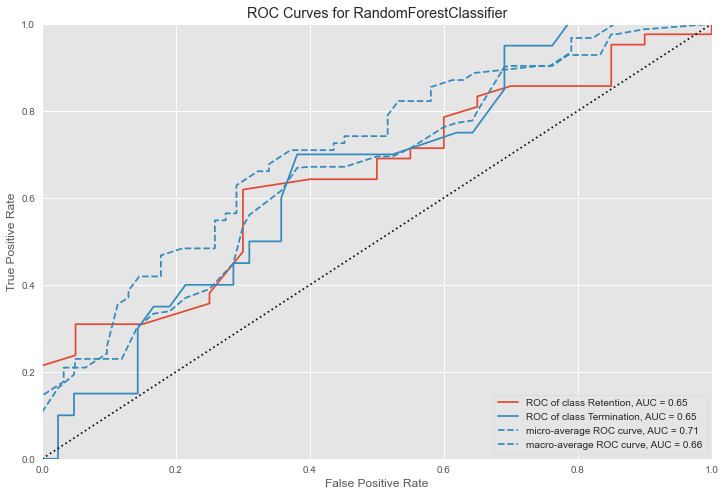

In [26]:
forest_roc = RandomForestClassifier(max_depth=None, random_state=0)

visualizer = ROCAUC(forest_roc, classes=['Retention','Termination'])
visualizer.fit(bigx_train, y_train)
visualizer.score(bigx_test, y_test)
visualizer.poof() ;

<h4>The tree from the forest</h4>

Notice how the Random Forest and Decision Tree don't necessarily weigh the same features in the same manner. By implimenting ensemble learning with our Random Forest, we are able to mitigate the Decision Tree's high variance and arrive at more normalized conclusions. Over many iterations, our forest can tease out increasingly abstract connections between the features that a lone tree might miss. While more computationally demanding, this results in a model that is more accurate and reliable. The main drawback is that a Random Forest is intristically less transparent in the "how" of its conclusions: we can look at a single tree and identify our model is predicting outcomes based on realistic or sound interpretations of our data as it branches. A Random Forest is a Kafkaesque monstrosity by comparison, with hundreds if not thousands of leaf nodes: the inner workings of how and why largely remain a mystery. In these cases it is especially important that we work to refine our model, that our training data is robust, and that we carefully monitor the impact that paramater changes have over the model's lifespan.

<h4>Conclusion</h4>

We've covered a lot of ground!
- cleaned and validated our data set
- performed an initial exploration
- used Pandas to modify our imported data to suit our project's needs
- identified and accounted for a class imbalance within our data set
- successfully implimented both a Decision Tree and Random Forest using our own training and validation sets
- explored our feature analysis to discover the key indicators of churn
- measured the effectiveness of our current model using ROC charts

If you've gotten all the way down here, I'd like to thank you for your time! I hope this served as a good example of how we can quickly impliment machine learning techniques to arrive at data-driven insights into the *"whys"* of employee behavior, and how those insights can be used not only to forecast outcomes but also act as early warnings and increase the overall retention of staff within an organization. If you're curious about some of the other projects I've done, <a href="https://github.com/travisyardley?tab=repositories" target="_blank">please explore my GitHub!</a> I forcus on business intelligence, data analysis and machine learning projects that helps leaders make informed, data-driven decisions in a timely manner. Have a great day!
